In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from src.utils import create_dataset, plot_matrix, compare_matrix, plot_matrix_cv
from sklearn.model_selection import KFold
from src.models.kernels import LambdaRBF, ARD_gpflow
from src.models.models import GPRLasso, SVGPLasso
from src.models.validation import measure_mnll, measure_rmse, kfold_cv_model
import matplotlib.pyplot as plt
import scipy
from sklearn.model_selection import train_test_split

2023-05-21 09:30:38.040673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generate a toy dataset given a specific precision matrix

In [2]:
def get_precision_dict(precision, reverse=True):
    precision = np.abs(precision)
    precision_dict = []
    d = precision.shape[0]
    for i in range(d):
        for j in range(d):
            precision_dict.append({'i': i, 'j': j, 'l': precision[i][j]}) if i <= j else None
    return sorted(precision_dict, key=lambda d: d['l'], reverse=reverse) 

In [3]:
def random_diag_precision(D):
    return np.diag(np.random.uniform(0,1,D))
def random_notdiag_precision(D):
    sparsity = 0.5
    precision = np.random.rand(D, D)
    precision[precision < sparsity] = 0
    precision = np.triu(precision) + np.triu(precision, 1).T
    return precision
def random_offdiag_precision(D, random_offdiag='no', n_offdiag=1):
    diag = np.ones(D)
    L = np.diag(diag, 0)
    if n_offdiag > D-1:
        n_offdiag = D-1
    for n in range(n_offdiag):
        i = n+1
        # define the offdiagonal
        if random_offdiag == 'no':
            offdiag = D**0.5 * np.ones(D-i)
        elif random_offdiag == 'uniform':
            offdiag = np.random.uniform(0, 1, D-i)
        elif random_offdiag == 'gaussian':
            offdiag = np.random.normal(-1, 1, D-i)
        # add it to the matrix L
        L += np.diag(offdiag, -i)
    # define the precision matrix
    precision = L @ L.T
    # normalize the precision matrix to have ones on the diagonal
    diag_m = np.diag(1/np.diag(precision))
    return (np.sqrt(diag_m) @ precision) @ np.sqrt(diag_m)

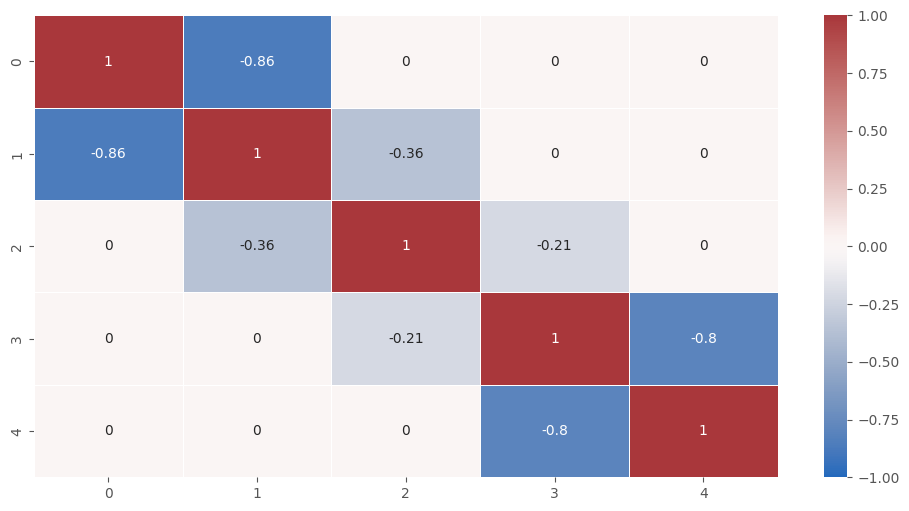

In [10]:
D = 5
precision = random_offdiag_precision(D, random_offdiag='gaussian', n_offdiag=1)
covariance = np.linalg.inv(precision) 
plot_matrix(precision)
#sqrt(diag)*precision*

In [11]:
def generate_dataset(precision, covariance, n=100, kernel_variance=1.0, noise_variance=0.1, random_state=0):
    d = covariance.shape[0]
    # sampling from known covariance 
    X = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)
    LRBF = LambdaRBF(variance=kernel_variance, randomized=False, d=d)
    K = LRBF.K_Lambda(X,precision).numpy()
    noise = np.random.normal(0, noise_variance, size=n)
    Y = (np.random.multivariate_normal(np.zeros(n), K, size=1) + noise).reshape(-1,1)
    # train-test split
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0) # center the dataset
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state, shuffle=True)
    Y_train_mean, Y_train_std = Y_train.mean(0), Y_train.std(0) + 1e-9
    Y_train = (Y_train - Y_train_mean) / Y_train_std
    Y_test = (Y_test - Y_train_mean) / Y_train_std
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test = generate_dataset(precision, covariance, noise_variance=0.1, kernel_variance=1, n=1000)

name,class,transform,prior,trainable,shape,dtype,value
GPRLasso.kernel.L,Parameter,Identity,,True,"(15,)",float64,"[0.44721, 0., 0...."
GPRLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPRLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


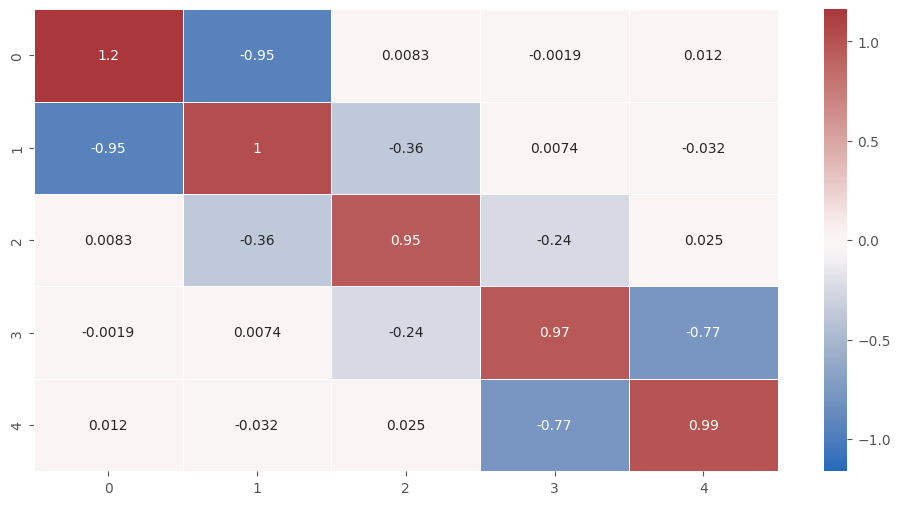

In [12]:
LRBF = LambdaRBF(variance=1.0, randomized=False, d=D)
model_params = {'num_inducing': 100, 'likelihood': gpflow.likelihoods.Gaussian(), 'max_iter': 10000, 'minibatch_size': 100, 'lasso': 10, 'tol_sparsity': 0.1}
gpr_lasso_LRBF = GPRLasso(data=(X_train, Y_train), kernel=LRBF, lasso=0)
gpflow.utilities.print_summary(gpr_lasso_LRBF, fmt="notebook")
gpr_lasso_LRBF.train()
plot_matrix(gpr_lasso_LRBF.kernel.precision())

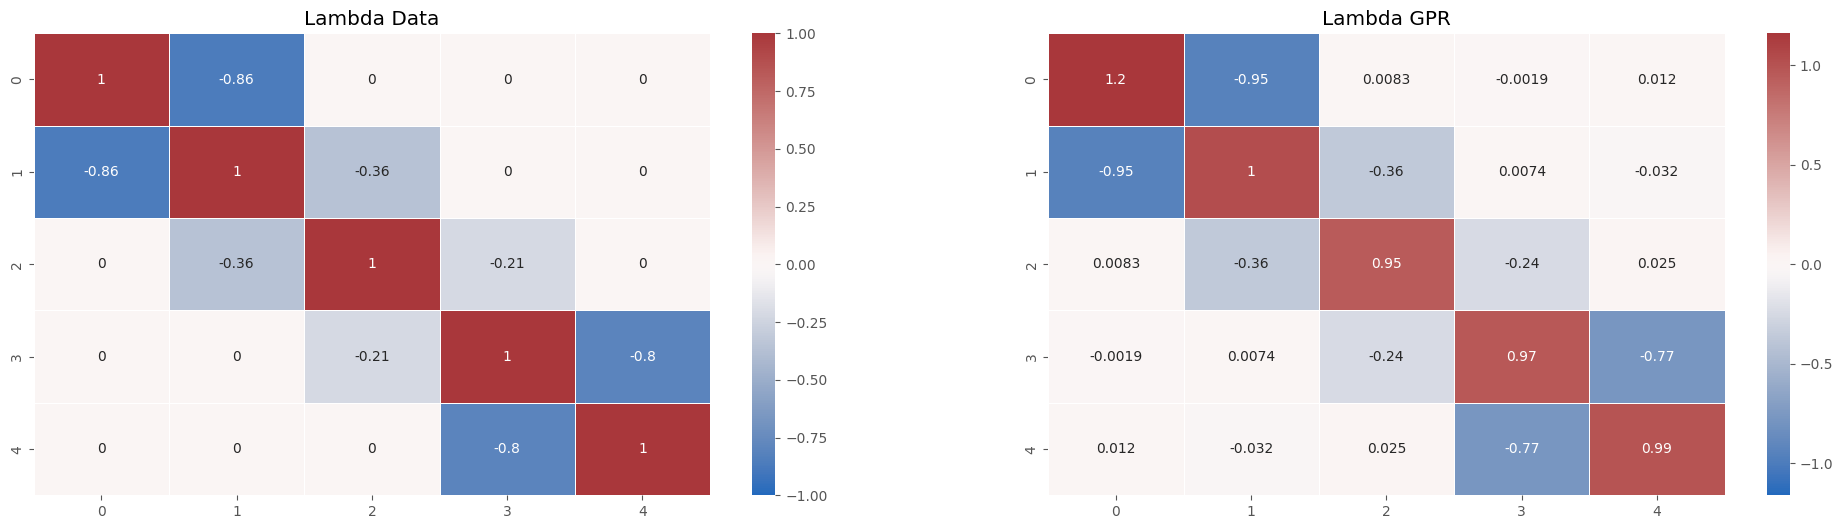

In [13]:
compare_matrix(precision, gpr_lasso_LRBF.kernel.precision(), titles=['Lambda Data', 'Lambda GPR'])

In [14]:
gpr_lasso_LRBF.likelihood.variance

<Parameter: name=chain_of_shift_of_softplus, dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.014826302880807798>

name,class,transform,prior,trainable,shape,dtype,value
GPRLasso.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPRLasso.kernel.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[2.23607, 2.23607, 2.23607..."
GPRLasso.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


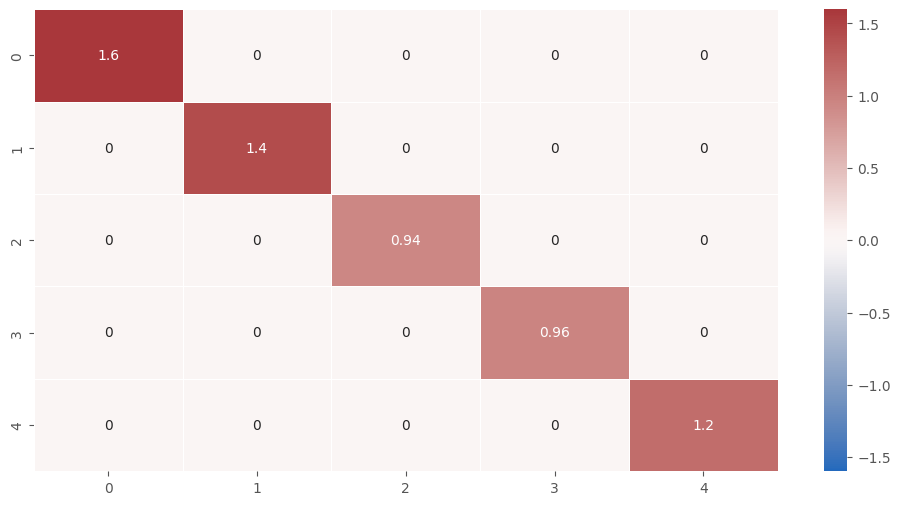

In [15]:
RBF_ARD = ARD_gpflow(variance=1.0, randomized=False, d=D)
gpr_lasso_RBF_ARD = GPRLasso(data=(X_train, Y_train), kernel=RBF_ARD, lasso=0)
gpflow.utilities.print_summary(gpr_lasso_RBF_ARD, fmt="notebook")
gpr_lasso_RBF_ARD.train()
plot_matrix(gpr_lasso_RBF_ARD.kernel.precision())

In [16]:
train_rmse_stan, test_rmse_stan = measure_rmse(gpr_lasso_RBF_ARD, X_train, Y_train, X_test, Y_test)
print('-- RBF ARD --')
print('Train RMSE: %.3f - Test RMSE: %.3f'%(train_rmse_stan, test_rmse_stan))
train_rmse_stan, test_rmse_stan = measure_rmse(gpr_lasso_LRBF, X_train, Y_train, X_test, Y_test)
print('-- RBF Lambda --')
print('Train RMSE: %.3f - Test RMSE: %.3f'%(train_rmse_stan, test_rmse_stan)) 

-- RBF ARD --
Train RMSE: 0.050 - Test RMSE: 0.484
-- RBF Lambda --
Train RMSE: 0.080 - Test RMSE: 0.310


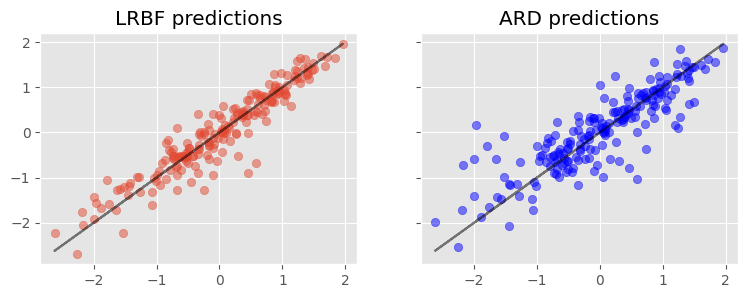

In [17]:
def plot_predicted_actual(model_LRBF, model_ARD, X, Y):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
    y_pred_train_LRBF, _ = model_LRBF.predict_f(X)
    y_pred_train_ARD, _ = model_ARD.predict_f(X)
    axs[0].scatter(Y, y_pred_train_LRBF, alpha=0.5)
    axs[0].plot(Y, Y, alpha=0.5, color='black')
    axs[0].set_title('LRBF predictions')
    axs[1].scatter(Y, y_pred_train_ARD, alpha=0.5, color='blue')
    axs[1].plot(Y, Y, alpha=0.5, color='black')
    axs[1].set_title('ARD predictions')
    plt.show()
plot_predicted_actual(gpr_lasso_LRBF, gpr_lasso_RBF_ARD, X_test, Y_test)

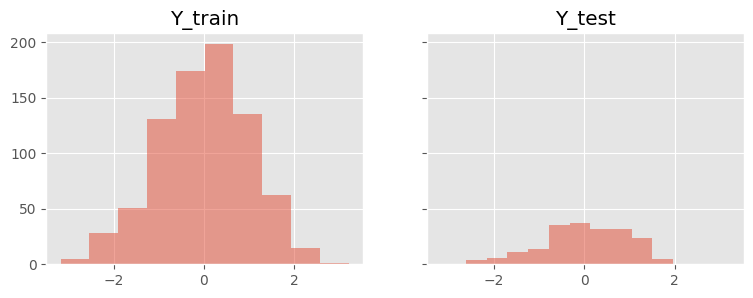

In [18]:
def plot_Y_distributions(Y_train, Y_test):
    fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey=True, sharex=True)
    axs[0].hist(Y_train, alpha=0.5)
    axs[0].set_title('Y_train')
    axs[1].hist(Y_test, alpha=0.5)
    axs[1].set_title('Y_test')
    plt.show()
plot_Y_distributions(Y_train, Y_test)

In [19]:
lengthscales_dict_sorted = gpr_lasso_RBF_ARD.kernel.lengthscales_dict()
lengthscales_dict_sorted

[{'i': 2, 'j': 2, 'l': 1.0315962162518109},
 {'i': 3, 'j': 3, 'l': 1.019689875206229},
 {'i': 4, 'j': 4, 'l': 0.9297067177576004},
 {'i': 1, 'j': 1, 'l': 0.8347341920861423},
 {'i': 0, 'j': 0, 'l': 0.7910753408619003}]

In [20]:
precision_dict_LRBF = gpr_lasso_LRBF.kernel.precision_dict()
precision_dict_LRBF

[{'i': 0, 'j': 0, 'l': 1.1610561117726428},
 {'i': 1, 'j': 1, 'l': 1.0325336856123213},
 {'i': 4, 'j': 4, 'l': 0.9903975325998002},
 {'i': 3, 'j': 3, 'l': 0.9700134624082025},
 {'i': 2, 'j': 2, 'l': 0.9494115236200151},
 {'i': 0, 'j': 1, 'l': 0.94715843007318},
 {'i': 3, 'j': 4, 'l': 0.7737144613475876},
 {'i': 1, 'j': 2, 'l': 0.36347260984625607},
 {'i': 2, 'j': 3, 'l': 0.24157858848641886},
 {'i': 1, 'j': 4, 'l': 0.03165736291759655},
 {'i': 2, 'j': 4, 'l': 0.025001435035413327},
 {'i': 0, 'j': 4, 'l': 0.01191300051466227},
 {'i': 0, 'j': 2, 'l': 0.008286414234765263},
 {'i': 1, 'j': 3, 'l': 0.007431149464669076},
 {'i': 0, 'j': 3, 'l': 0.001927908199420074}]

In [21]:
precision_dict_DATA = get_precision_dict(precision)
precision_dict_DATA

[{'i': 1, 'j': 1, 'l': 1.0000000000000002},
 {'i': 2, 'j': 2, 'l': 1.0000000000000002},
 {'i': 0, 'j': 0, 'l': 1.0},
 {'i': 4, 'j': 4, 'l': 1.0},
 {'i': 3, 'j': 3, 'l': 0.9999999999999999},
 {'i': 0, 'j': 1, 'l': 0.8604663135821952},
 {'i': 3, 'j': 4, 'l': 0.8032680432538442},
 {'i': 1, 'j': 2, 'l': 0.3599812023803155},
 {'i': 2, 'j': 3, 'l': 0.21119070506764653},
 {'i': 0, 'j': 2, 'l': 0.0},
 {'i': 0, 'j': 3, 'l': 0.0},
 {'i': 0, 'j': 4, 'l': 0.0},
 {'i': 1, 'j': 3, 'l': 0.0},
 {'i': 1, 'j': 4, 'l': 0.0},
 {'i': 2, 'j': 4, 'l': 0.0}]